# Modèle LSTM

Ce modèle permet de prédire la demande journalière des différents produits d'une supérette se trouvant à Dieupeul.

## Aperçu des données

### Description des champs

| Champ               | Type    | Description                                                                                     |
|---------------------|---------|-------------------------------------------------------------------------------------------------|
| `date`              | string  | Date au format `YYYY-MM-DD`.                                                                    |
| `produit`           | string  | Nom du produit (10 produits disponibles).                                                       |
| `categorie`         | string  | Catégorie du produit (`Laitage`, `Légumes`, `Fruits`, `Viandes`, `Poissons`, `Epicerie`).       |
| `prix_vente`        | integer | Prix de vente en FCFA (ajusté selon les événements).                                            |
| `demande_journaliere`| integer | Demande client estimée (loi de Poisson avec variations).                                        |
| `quantite_vendue`   | integer | Quantité réellement vendue (`min(demande_journaliere, stock_initial)`).                         |
| `ventes_perdues`    | integer | Demande non satisfaite (`demande_journaliere - quantite_vendue`).                               |
| `stock_initial`     | integer | Stock disponible en début de journée.                                                           |
| `duree_peremption`  | integer | Durée de péremption en jours (spécifique au produit).                                           |
| `temperature`       | float   | Température maximale quotidienne à Dakar (°C).                                                   |
| `promotion`         | integer | Indicateur de promotion (`0 = non`, `1 = oui`).                                                 |
| `jour_semaine`      | string  | Nom du jour en français (ex: Lundi).                                                            |
| `weekend`           | integer | Indicateur weekend (`1 = weekend`, `0 = jour ouvré`).                                           |
| `evenement`         | string  | Événement en cours (`Ramadan`, `Aid_el_Fitr`, `Tabaski`, `Tabaski_JourJ`, `Aucun`).             |
| `chiffre_affaires`  | integer | Chiffre d'affaires journalier (`quantite_vendue × prix_vente`).                                 |

### Exemples de données

| date       | produit        | categorie | prix_vente | demande_journaliere | quantite_vendue | ventes_perdues | stock_initial | duree_peremption | temperature | promotion | jour_semaine | weekend | evenement | chiffre_affaires |
|------------|----------------|-----------|------------|----------------------|------------------|----------------|---------------|------------------|-------------|-----------|--------------|---------|-----------|------------------|
| 2022-01-01 | Lait_1L        | Laitage   | 1219       | 197                  | 101              | 96             | 101           | 7                | 31.66435964585924 | 0         | Saturday  | 1           | Aucun   | 123119    |
| 2022-01-01 | Yaourt         | Laitage   | 500        | 305                  | 100              | 205            | 100           | 5                | 36.627680130757895 | 0         | Saturday  | 1           | Aucun   | 50000     |
| 2022-01-01 | Tomates_kg     | Légumes   | 267        | 217                  | 119              | 98             | 119           | 5                | 32.88996859487778 | 0         | Saturday  | 1           | Aucun   | 31773     |
| 2022-01-01 | Oignons_kg     | Légumes   | 689        | 182                  | 90               | 92             | 90            | 10               | 35.332767769129596 | 0         | Saturday  | 1           | Aucun   | 62010     |
| 2022-01-01 | Bananes_kg     | Fruits    | 2463       | 113                  | 87               | 26             | 87            | 5                | 33.198083930243584 | 0         | Saturday  | 1           | Aucun   | 214281    |


## Importations des Dependaces

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from google.colab import files


In [2]:
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

Saving dataset_stock_final_dieupeul.csv to dataset_stock_final_dieupeul.csv


## Pretraitement des donnees et Sauvegarde des caracteristiques

In [3]:
# Charger les données
# df = pd.read_csv('/content/dataset_stock_final_dieupeul.csv')

# Préprocessing
df['date'] = pd.to_datetime(df['date'])

# Extraire les composantes de la date
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['weekday'] = df['date'].dt.weekday  # Lundi = 0, Dimanche = 6

# Encodage des catégories
label_encoders = {}
for col in ['produit', 'categorie', 'evenement']:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

# Sélection des features et target
features = [
    'prix_vente', 'quantite_vendue', 'ventes_perdues', 'stock_initial',
    'duree_peremption', 'temperature', 'promotion', 'weekend',
    'day', 'month', 'year', 'weekday',
    'produit_encoded', 'categorie_encoded', 'evenement_encoded'
]
target = 'demande_journaliere'

# Normalisation des features numériques
numeric_cols = ['prix_vente', 'quantite_vendue', 'ventes_perdues',
               'stock_initial', 'duree_peremption', 'temperature',
               'chiffre_affaires', 'day', 'month', 'year']
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Normalisation de la cible
target_scaler = MinMaxScaler()
df[target] = target_scaler.fit_transform(df[[target]])

# Sauvegarder les scalers
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(target_scaler, 'target_scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')


['label_encoders.pkl']

## Entrainement et Sauvegarde du modele

In [4]:

# Extraire les valeurs des features et de la target après normalisation
X = df[features].values
y = df[target].values

# Créer les séquences temporelles
def create_sequences(X, y, time_steps=7):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        labels = y[i + time_steps]
        Xs.append(v)
        ys.append(labels)
    return np.array(Xs), np.array(ys)

time_steps = 7
X_seq, y_seq = create_sequences(X, y, time_steps)

# Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Construction du modèle LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_seq.shape[1], X_seq.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Entraîner le modèle uniquement sur l'ensemble d'entraînement
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Sauvegarder le modèle
model.save('modele_lstm.h5')

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


241/241 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0296 - val_loss: 0.0103
Epoch 2/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0110 - val_loss: 0.0038
Epoch 3/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0067 - val_loss: 0.0026
Epoch 4/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 5/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 6/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0034 - val_loss: 0.0015
Epoch 7/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 8/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 9/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 10/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 11/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0022 - val_loss: 0.0010
Epoch 12/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 3s 12m

## Fonction de Prediction pour le Backend

In [5]:
import joblib
from datetime import timedelta

# Charger le modèle et les scalers
model = tf.keras.models.load_model('modele_lstm.h5')
scaler = joblib.load('scaler.pkl')
target_scaler = joblib.load('target_scaler.pkl')
label_encoders = joblib.load('label_encoders.pkl')

def predict_demand(start_date, end_date, product_name):
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Filtrer les données pour le produit spécifié
    product_data = df[df['produit'] == product_name].copy()
    product_data.sort_values('date', inplace=True)

    # Préparer les données pour ce produit
    product_X = product_data[features].values
    product_y = product_data[target].values

    # Créer les séquences temporelles pour le produit
    X_seq_product, _ = create_sequences(product_X, product_y, time_steps)

    # Faire les prédictions
    product_predictions = model.predict(X_seq_product)

    # Inverser la normalisation des prédictions avec le scaler spécifique pour la cible
    product_predictions = product_predictions.reshape(-1, 1)
    product_predictions = target_scaler.inverse_transform(product_predictions).flatten()

    # Accumuler les prédictions par jour
    date_range = pd.date_range(start=start_date, end=end_date)
    daily_predictions = {date: 0 for date in date_range}

    # Remplir les prédictions pour les dates correspondantes
    current_date = start_date
    for pred in product_predictions:
        if current_date > end_date:
            break
        if current_date in daily_predictions:
            daily_predictions[current_date] += pred
        current_date += timedelta(days=1)

    return daily_predictions



## Test Prediction

In [6]:
# Exemple d'utilisation
start_date = '2025-01-01'
end_date = '2025-01-10'
product_name = 'Tomates_kg'
predictions = predict_demand(start_date, end_date, product_name)

# Afficher les prédictions finales
# print("Prédictions finales:")
# for date, pred in predictions.items():
#     print(f"{date}: {pred}")
predictions


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


{Timestamp('2025-01-01 00:00:00'): 93.02780151367188,
 Timestamp('2025-01-02 00:00:00'): 107.39630889892578,
 Timestamp('2025-01-03 00:00:00'): 116.72136688232422,
 Timestamp('2025-01-04 00:00:00'): 103.38040161132812,
 Timestamp('2025-01-05 00:00:00'): 93.02570343017578,
 Timestamp('2025-01-06 00:00:00'): 88.56291198730469,
 Timestamp('2025-01-07 00:00:00'): 88.39037322998047,
 Timestamp('2025-01-08 00:00:00'): 92.50212860107422,
 Timestamp('2025-01-09 00:00:00'): 107.54126739501953,
 Timestamp('2025-01-10 00:00:00'): 117.98401641845703}

# Evaluation du modele

In [7]:

# Faire des prédictions sur l'ensemble de test
y_pred_scaled = model.predict(X_test)

# Inverser la normalisation des prédictions et des vraies valeurs
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_true = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculer les métriques
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2}')


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean Squared Error (MSE): 178.8423315633777
Mean Absolute Error (MAE): 10.361595546358354
R-squared (R2): 0.9758577928934039


## Visualisation des résultats


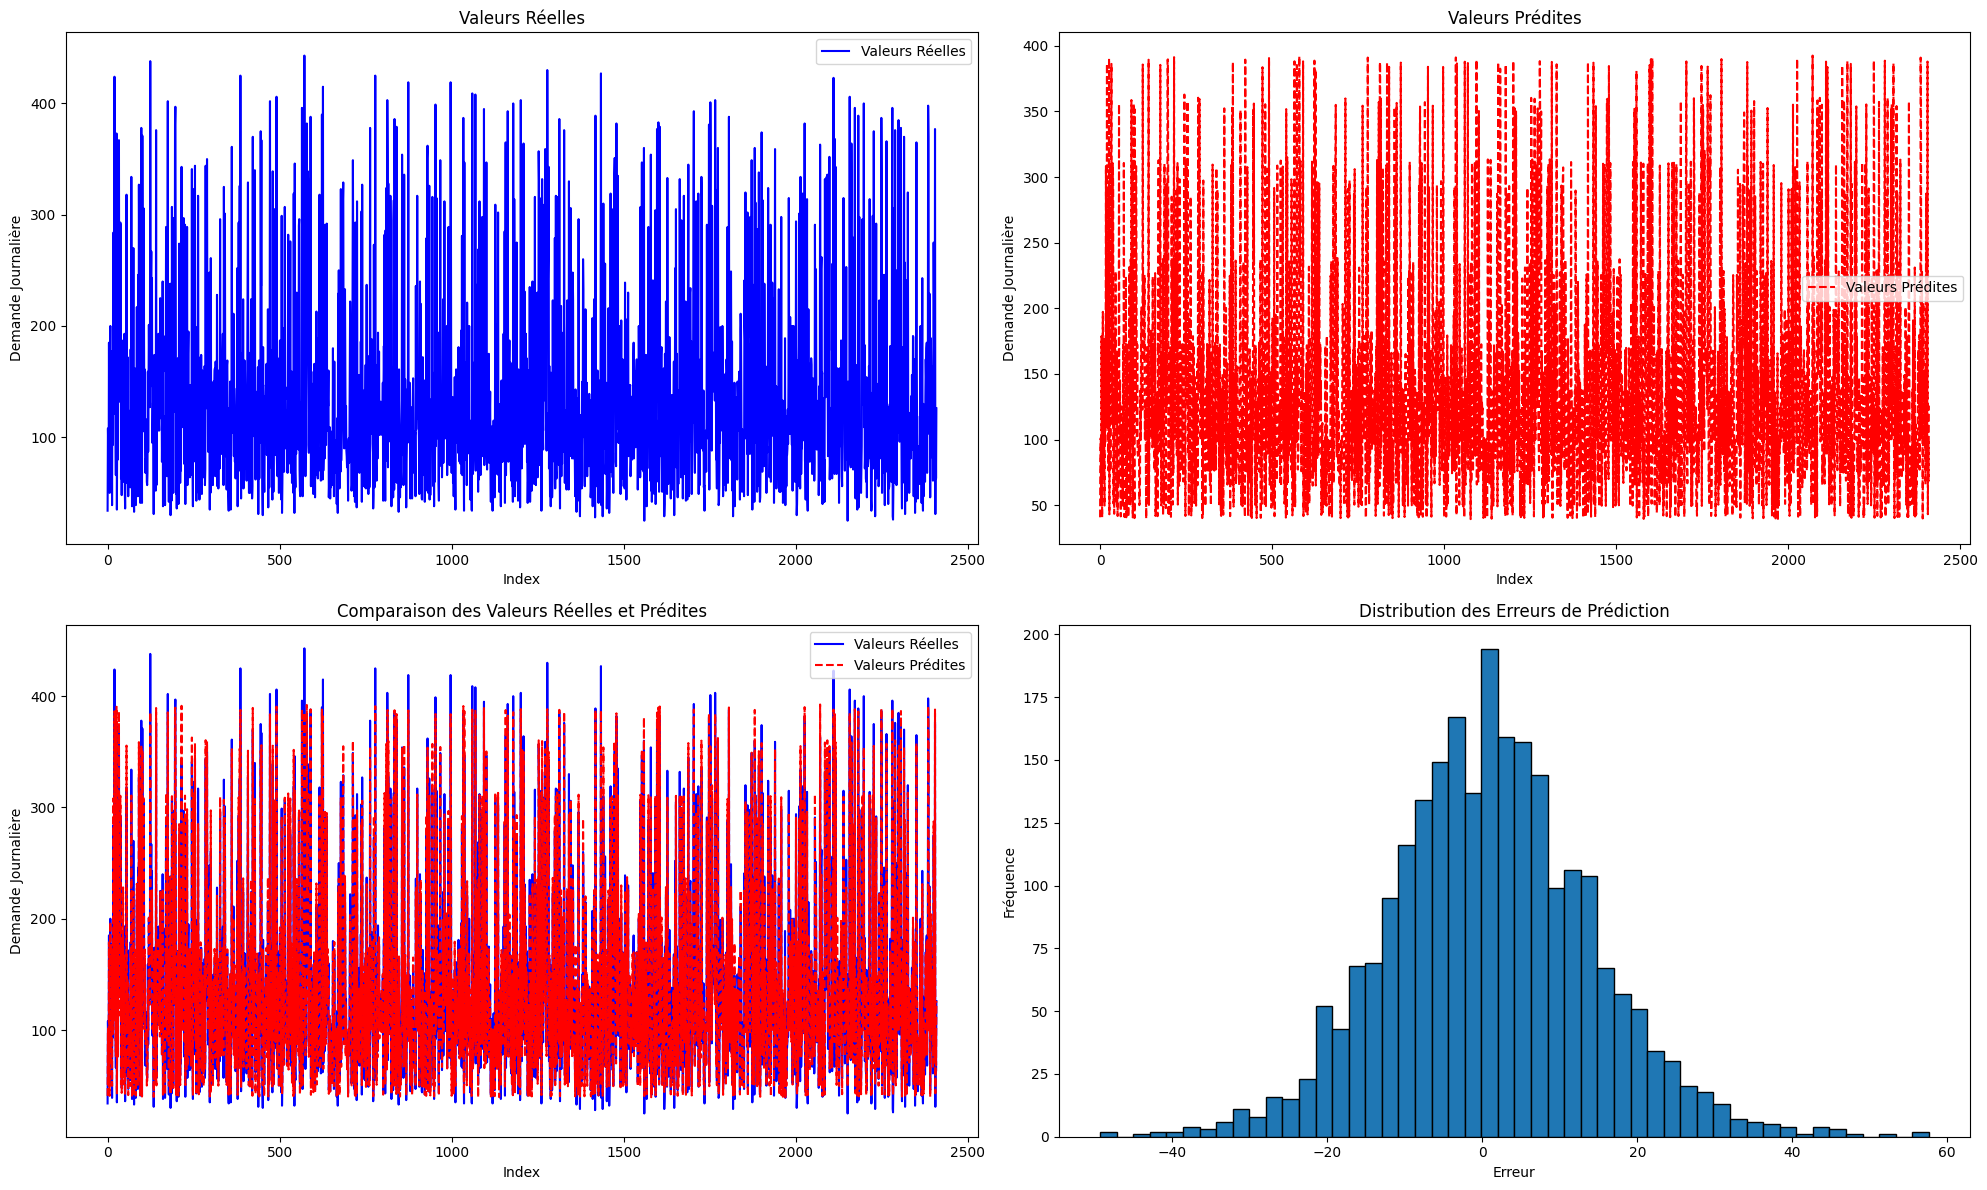

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Visualiser les résultats dans un subplot
fig, axs = plt.subplots(2, 2, figsize=(20, 12))

# Graphique 1: Valeurs Réelles
axs[0, 0].plot(y_true, label='Valeurs Réelles', color='blue')
axs[0, 0].set_xlabel('Index')
axs[0, 0].set_ylabel('Demande Journalière')
axs[0, 0].set_title('Valeurs Réelles')
axs[0, 0].legend()

# Graphique 2: Valeurs Prédites
axs[0, 1].plot(y_pred, label='Valeurs Prédites', color='red', linestyle='--')
axs[0, 1].set_xlabel('Index')
axs[0, 1].set_ylabel('Demande Journalière')
axs[0, 1].set_title('Valeurs Prédites')
axs[0, 1].legend()

# Graphique 3: Superposition des Valeurs Réelles et Prédites
axs[1, 0].plot(y_true, label='Valeurs Réelles', color='blue')
axs[1, 0].plot(y_pred, label='Valeurs Prédites', color='red', linestyle='--')
axs[1, 0].set_xlabel('Index')
axs[1, 0].set_ylabel('Demande Journalière')
axs[1, 0].set_title('Comparaison des Valeurs Réelles et Prédites')
axs[1, 0].legend()

# Calculer les erreurs
errors = y_true - y_pred

# Graphique 4: Distribution des Erreurs de Prédiction
axs[1, 1].hist(errors, bins=50, edgecolor='black')
axs[1, 1].set_xlabel('Erreur')
axs[1, 1].set_ylabel('Fréquence')
axs[1, 1].set_title('Distribution des Erreurs de Prédiction')

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()

# Auteur : Seny Toutou Diedhiou


- **Phone**: +221 77 587 89 34
- **Email**: senytoutou@gmail.com
- **Address**: Dieupeul, Dakar
- **LinkedIn**: [seny-toutou-diedhiou](https://www.linkedin.com/in/seny-toutou-diedhiou)
- **Github** : [Setoudie](https://github.com/setoudie)
- **Portfolio**: [seny-toutou-diedhiou](https://setoudie.github.io/)
